# Lecture 8 - 4/25

I set up a git hub repository for notes in jupyter notebook formats. You can find it through this link: https://github.com/Fay-Wu/134Note You can clone it to your own notebook and play with the codes.
 

# Shooting Pattern Analysis

In this analysis, we analyze the shotchart of players. We show that there are different modes of shots, and each player's shooting style can be described as some combination of these modes.

To clean up the notebook, some functions have been moved to a local module: `helper_basketball.py`. **Make sure this file is in the same directory with this notebook, otherwise the first cell below won't run.**

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import pickle

import helper_basketball as h
import imp
imp.reload(h);

In [3]:
%%bash
cat helper_basketball.py

def get_nba_data(endpoint, params, return_url=False):
    
    """Retrieves data from http://stats.nba.com
    
    For community documentation, visit 
    https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation.
    
    Args:
        endpoint: endpoint specifies data table
        params: dictionary of parameters: e.g., {'LeagueID':'00'}
        return_url: returns URL instead of downloading data then returning it
    Returns:
        out: Pandas data frame
    """
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    import subprocess as sp
    
    useragent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9"
    dataurl = "http://stats.nba.com/stats/" + endpoint + "?" + urlencode(params)
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    wgetout = sp.Popen(['wget', '-q', '-O', '-', '--user-agent='+user

When looking at the ```helper_basketball.py```
under the ```def get_nba_data...``` there are a bunch of script that is under the """ """. This will be printedas the docstring.

## Import a python file as a module

File `helper_basketball.py` is imported as a module, and can be used like any other module. For example, you can get the docstring and function source using ? and ??, respectively.

In [24]:
## h.get_nba_data?
## h.get_nba_data??

## Get team and player data

In [5]:
## get all 2016-17 teams
params = {'LeagueID':'00','Season': '2016-17'}
teams = h.get_nba_data('commonTeamYears', params).set_index('TEAM_ID')
allteams = teams.loc[teams.MAX_YEAR=='2017'].index.values

## get all 2016-17 players
params = {'LeagueID':'00', 'Season': '2016-17', 'IsOnlyCurrentSeason': '0'}
players = h.get_nba_data('commonallplayers', params).set_index('PERSON_ID')
allplyrs = players.loc[players.TEAM_ID.isin(allteams)].index.values

## Get shooting data

We follow the data collection procedure described in this paper: https://arxiv.org/abs/1401.0942.

The data consists of all shots attempted by anyone during the regular season of 2016-17. The shots are filtered in the 50' x 35' offensive court then only those who made more than 50 are included. Since the process takes a long time, I commented out the code for downloading the data, but, instead, saved the data into a pickle file.

In [25]:
## params = {'PlayerID':'201939',
##           'PlayerPosition':'',
##           'Season':'2016-17',
##           'ContextMeasure':'FGA',
##           'DateFrom':'',
##           'DateTo':'',
##           'GameID':'',
##           'GameSegment':'',
##           'LastNGames':'0',
##           'LeagueID':'00',
##           'Location':'',
##           'Month':'0',
##           'OpponentTeamID':'0',
##           'Outcome':'',
##           'Period':'0',
##           'Position':'',
##           'RookieYear':'',
##           'SeasonSegment':'',
##           'SeasonType':'Regular Season',
##           'TeamID':'0',
##           'VsConference':'',
##           'VsDivision':''}
## 
## shotdf = []
## for p in allplyrs:
##     
##     ## get player p's data
##     params['PlayerID'] = p
##     shotdata = h.get_nba_data('shotchartdetail', params)
##     
##     ## subset columns
##     sc = shotdata.loc[:,'SHOT_DISTANCE':'SHOT_MADE_FLAG']
##     sc.drop('SHOT_ATTEMPTED_FLAG', axis=1)
##     
##     ## filter shots to 31 feet from end zone
##     sc = sc.loc[sc.LOC_Y < (31*12)]
##     
##     ## keep data with more than 50 shots
##     
##     if sc.SHOT_MADE_FLAG.sum() > 50:
##         
##         sc['PlayerID'] = p
##         shotdf += [sc]
## 
## allshots = pd.concat(shotdf)
## 
## pickle.dump(allshots, open('allshots2016-17.pkl', 'wb'))

## Pickle module

A `pickle` file is a python module for saving data objects into a file.

In [7]:
allshots = pickle.load(open('allshots2016-17.pkl', 'rb'))

# allmade = allshots.loc[allshots.SHOT_MADE_FLAG==1]
allmade = allshots
allmade.head()

,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,PlayerID
0,21,94,188,1,0,203518
1,26,-160,205,1,1,203518
2,2,20,3,1,1,203518
3,26,-150,219,1,1,203518
4,26,-52,257,1,0,203518


## Data preprocessing

We want to limit X and Y locations to 35 feet (length-wise) by 50 feet (width-wise). Data contains more of the court:

In [8]:
pd.DataFrame([allmade.LOC_X.describe(), 
              allmade.LOC_Y.describe()])

,count,mean,std,min,25%,50%,75%,max
LOC_X,202153.0,-0.245285,110.854723,-250.0,-53.0,0.0,52.0,250.0
LOC_Y,202153.0,85.151954,88.685467,-51.0,7.0,46.0,164.0,370.0


## Binned shot counts

We divide the court up into bins, and, for each player, count number of shots that fall into each bin. Then, we vectorize the bins into a row vector.

In [9]:
## players info
player_ids = allmade.PlayerID.unique()
num_players = player_ids.size

## bin edge definitions in inches
xedges = (np.linspace(start=-25, stop=25, num=151, dtype=np.float)) * 12
yedges = (np.linspace(start= -4, stop=31, num=106, dtype=np.float)) * 12

## number of bins is one less than number of edges
nx = xedges.size - 1
ny = yedges.size - 1

## 2d histogram containers for binned counts and smoothed binned counts
all_counts = {}
all_smooth = {}

## data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allmade.groupby('PlayerID')):
    
    ## what does this line do? saved into separate variable
    pid, pdf = one
    
    ## h.bin_shots: what is this function doing? passing in shot data to the player
    tmp1, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
    tmp2, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
    ## vectorize and store into dictionary, takes the bin output(in matrix form) and vectorize it into a long vector
    all_smooth[pid] = tmp1.reshape(-1)
    all_counts[pid] = tmp2.reshape(-1)

## Kernel smoothing (filtering)

Kernel smoothing is a frequently used function in image processing. It can also be used to smooth-out the histogram. Then, the smoothed histogram is normalized to sum to 1 to create an empirical distribution function. It is important we do this since each player has attempted different number of shots, and this procedure normalizes everyone's shooting pattern.

What is the name of the kernel smoothing function?

In [10]:
# h.bin_shots??

## Visualizing star players

We will visualize the shot chart counts and smoothed fields for some players. Recall the player data structure.

In [11]:
players.head()

,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
PERSON_ID,,,,,,,,,,,,
76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,,,,,Y
76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,,,,,Y
76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,,,,,Y
51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,mahmoud_abdul-rauf,0,,,,,Y
1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,,,,,Y


In [12]:
## select players from paper
stars = 'LeBron James|Brook Lopez|Tyson Chandler|Marc Gasol|Tony Parker|Kyrie Irving|Stephen Curry|James Harden|Steve Novak'
starids = players[players.DISPLAY_FIRST_LAST.str.contains(stars)].loc[player_ids].dropna()
#grab the players in player dataframe that matches the starts. drop NA because there are no matches.

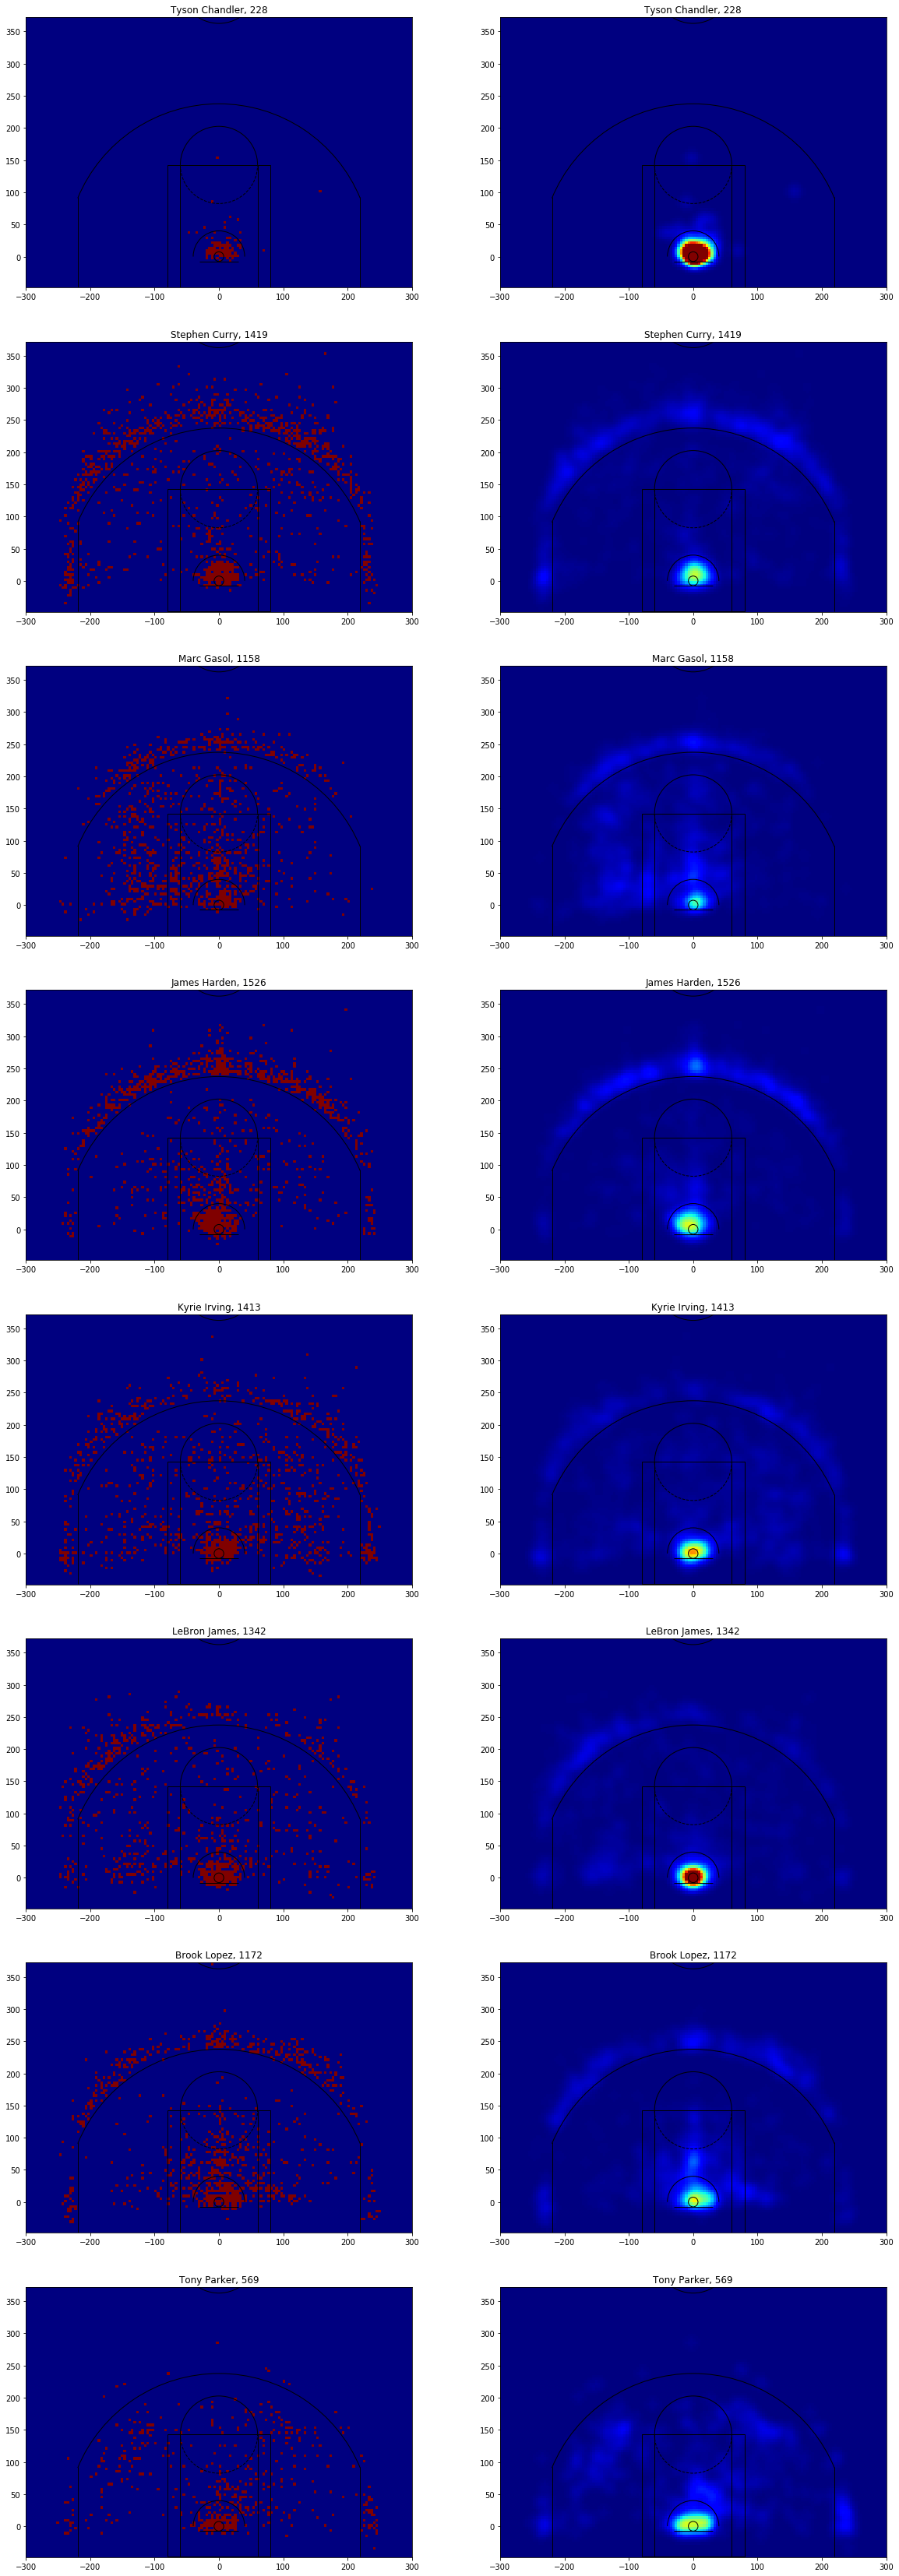

In [13]:
## create figure and axes
fig, ax = plt.subplots(starids.shape[0], 2, figsize=(20,60))

for axi, plyri in enumerate(starids.index.values):
    
    h.plot_shotchart(all_counts[plyri], xedges, yedges, ax=ax[axi,0])
    h.plot_shotchart(all_smooth[plyri], xedges, yedges, ax=ax[axi,1])
    
    ax[axi,0].set_title(players.DISPLAY_FIRST_LAST[plyri]+', '+str(all_counts[plyri].sum().astype('int')))
    ax[axi,1].set_title(players.DISPLAY_FIRST_LAST[plyri]+', '+str(all_counts[plyri].sum().astype('int')))

## Non-negative matrix factorization (NMF)

Given some matrix $X$ is $p\times n$ matrix, NMF computes the following factorization:
$$ \min_{W,H} \| X - WH \|_F\\
\text{ subject to } W\geq 0,\ H\geq 0, $$
where $W$ is ${p\times r}$ matrix and $H$ is ${r\times n}$ matrix.

NMF is a unique factorization in that all values are non-negative; hence, it is used for factorization of $X$ into bases consist of non-negative values. In many practical settings such assumptions enable some realistic interpretation.

Some common applications include:
- Image processing: pixel intensities are non-negative
- Bioinformatics: gene expressions are non-negative
- Text mining: document term matrix

[This paper](https://arxiv.org/abs/1401.5226) discusses some of these in more detail.

In our case, columns of matrix $X$ represent vectorized smoothed density of one player, and we compute the non-negative $r$-bases vectors in matrix $W$. Columns in matrix $H$ are the vector of coefficients. Each coefficient in a column says how important each of the bases (columns of $W$) are.

In [14]:
## Non-negative Matrix Factorization

import sklearn.decomposition as skld

X = np.stack(all_smooth.values()).T

## what are the different options mean for NMF()?
model = skld.NMF(n_components=10, init='nndsvda', max_iter=500, random_state=0)
W = model.fit_transform(X)
H = model.components_

### Data matrix: $X$

Data matrix $X^T$ has dimensions of (number of players)-by-(number of bins), so $X$ is of dimension $n=\text{\{number of players\}}$ and $p=\text{\{number of bins\}}$.

In [15]:
p, n = X.shape

print('Number of bins (p)   :', p)
print('Number of players (n):', n)

Number of bins (p)   : 15750
Number of players (n): 362


### Bases matrix: $W$

Columns $W_i$ contain the bases. Since the function call asks for $r=10$ as number of bases, we get:

In [16]:
p_w, r = W.shape

print('Number of bins (p) :', p_w)
print('Number of bases (r):', r)

Number of bins (p) : 15750
Number of bases (r): 10


It has the shape of (number of bins)-by-(10 components).

### Coefficient matrix: H

Each column of $H$ gives a coefficient for each of the bases vectors in $W$, and there are $n$ columns for each player.

In [17]:
r_h, n_h = H.shape

print('Number of bases (r)  :', r_h)
print('Number of players (n):', n_h)

Number of bases (r)  : 10
Number of players (n): 362


### Visualizing the Bases $W$

Each column vector of $W$ gives a spatial basis. Below we plot the bases in 2-d space.

In [18]:
## h.plot_shotchart??

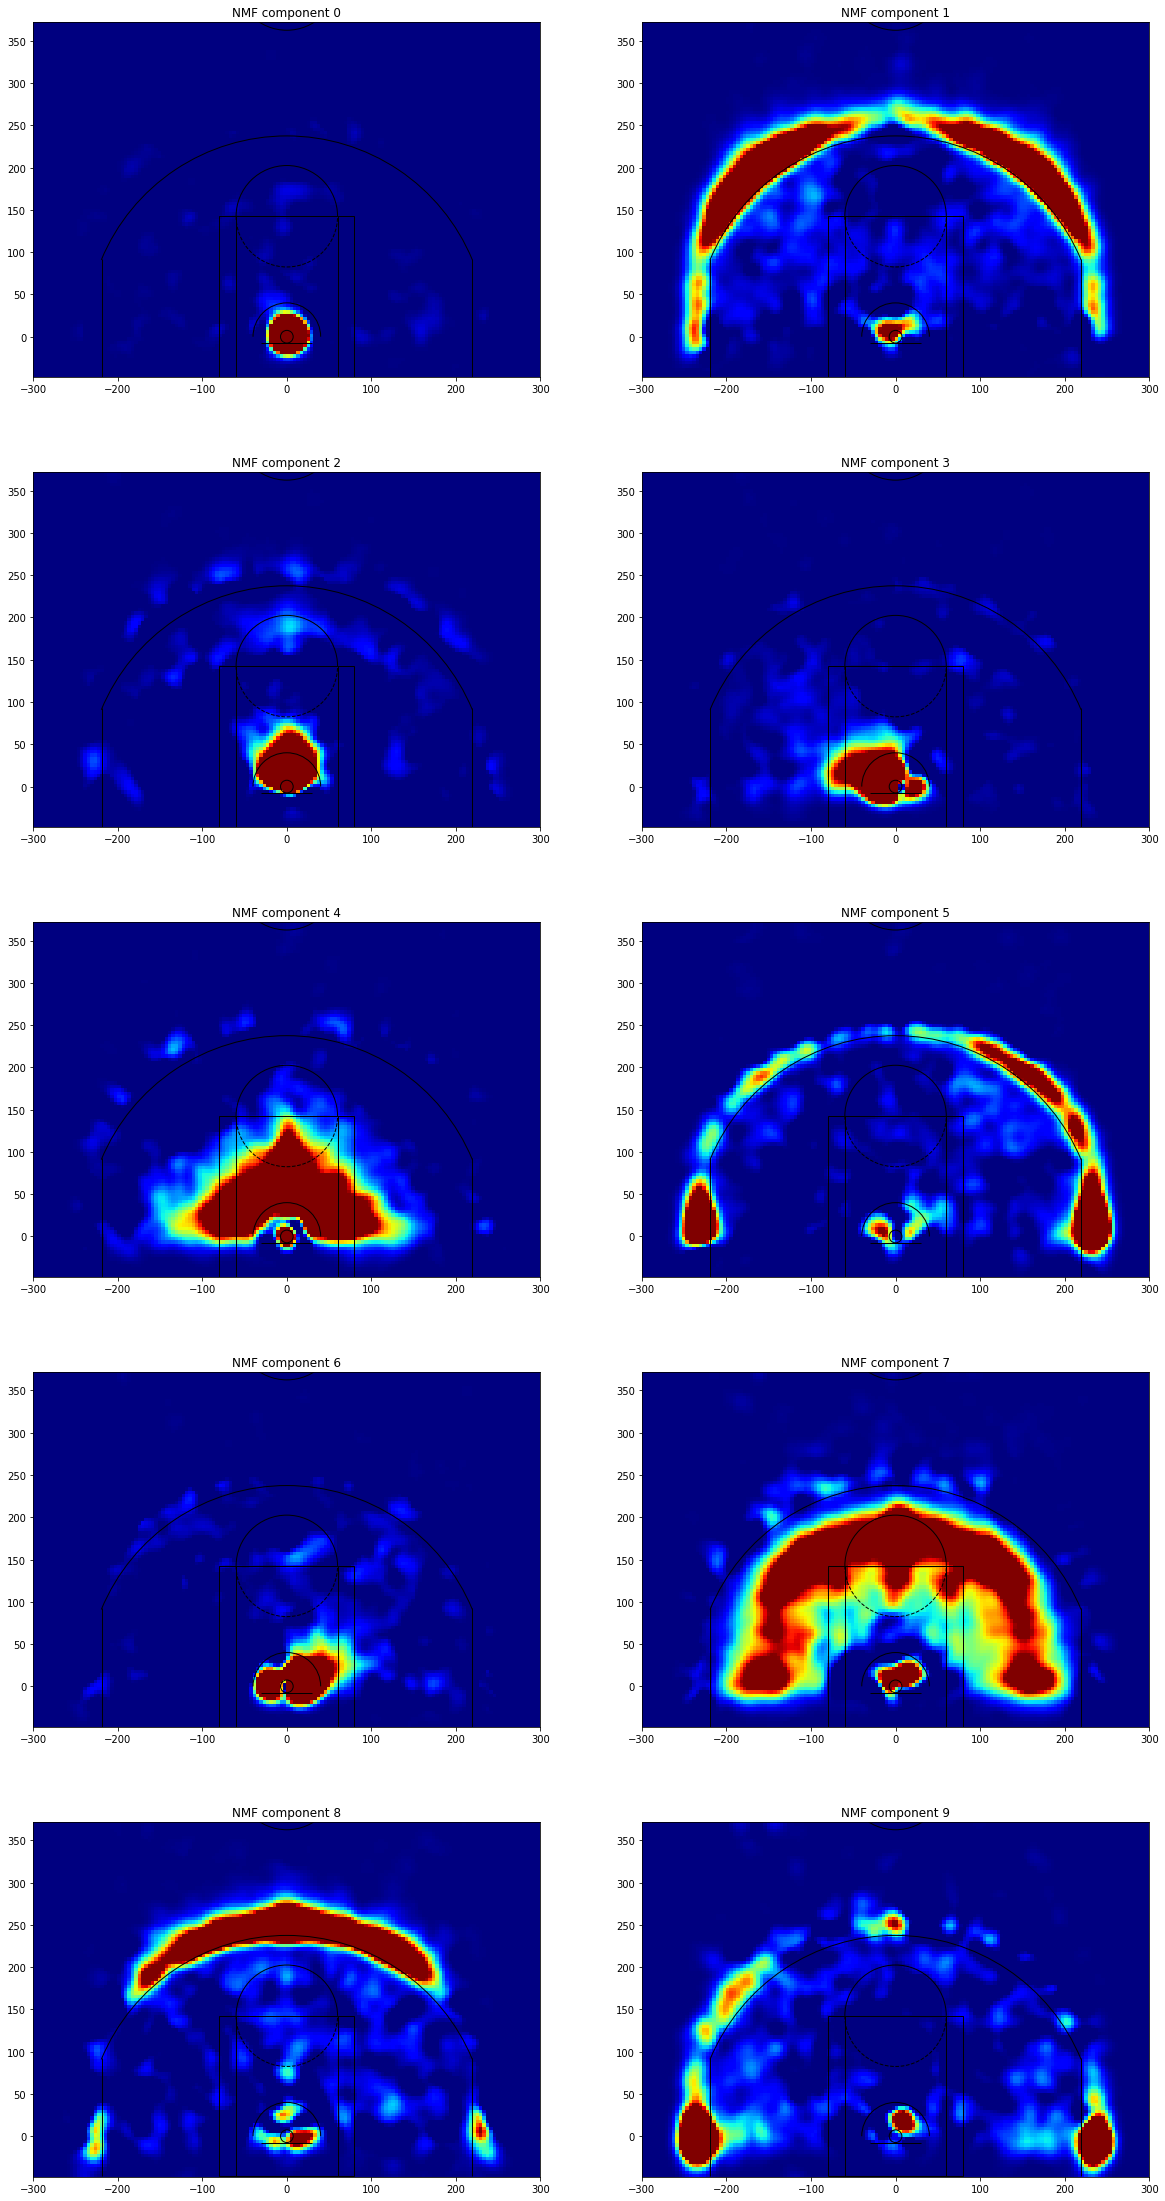

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(20,40))

for i, axi in enumerate(ax.flatten()):
    h.plot_shotchart(W[:,i], xedges, yedges, ax=axi)
    axi.set_title('NMF component ' + str(i))

## Interpreting the players shooting styles

Let's inspect the players shooting styles by looking at the coefficients.

In [20]:
## Hd holds coefficients
Hd = pd.DataFrame(H, columns=all_smooth.keys())
star_coeff = Hd.loc[:,starids.index.values]
star_coeff.columns = starids.DISPLAY_FIRST_LAST
star_coeff.T

,0,1,2,3,4,5,6,7,8,9
DISPLAY_FIRST_LAST,,,,,,,,,,
Tyson Chandler,0.111631,0.000000,0.027279,0.010768,0.000000,0.000000,0.034618,0.000000,0.000000,0.000000
Stephen Curry,0.009250,0.021969,0.018736,0.006220,0.000022,0.003531,0.007474,0.005048,0.012018,0.005338
Marc Gasol,0.008516,0.005520,0.005609,0.002495,0.021601,0.000000,0.004573,0.014309,0.015899,0.000000
James Harden,0.010243,0.015804,0.015428,0.022543,0.006203,0.000875,0.001153,0.002633,0.026454,0.000000
Kyrie Irving,0.020617,0.013418,0.002932,0.015083,0.005778,0.004031,0.010586,0.011560,0.004585,0.005547
LeBron James,0.054129,0.013394,0.000000,0.021702,0.005866,0.000000,0.008174,0.006416,0.003715,0.003882
Brook Lopez,0.013169,0.012208,0.007942,0.006075,0.024254,0.000000,0.014692,0.000876,0.012677,0.004907
Tony Parker,0.012646,0.000000,0.003166,0.021790,0.013497,0.013197,0.017431,0.016279,0.000000,0.002828


Note that these players coefficients are not scaled to sum to 1.

In [21]:
star_coeff.T.sum(1)

DISPLAY_FIRST_LAST
Tyson Chandler    0.184297
Stephen Curry     0.089606
Marc Gasol        0.078523
James Harden      0.101335
Kyrie Irving      0.094137
LeBron James      0.117279
Brook Lopez       0.096800
Tony Parker       0.100836
dtype: float64

So we scale each player to sum to 1.

In [22]:
star_coeff /= star_coeff.sum(0) # /= means star_coeff = star_coeff/star_coeff.sum(0)
#same algorithm goes with +=, -=, etc.
star_coeff.T

,0,1,2,3,4,5,6,7,8,9
DISPLAY_FIRST_LAST,,,,,,,,,,
Tyson Chandler,0.605713,0.000000,0.148017,0.058430,0.000000,0.000000,0.187841,0.000000,0.000000,0.000000
Stephen Curry,0.103234,0.245169,0.209090,0.069417,0.000241,0.039410,0.083407,0.056338,0.134125,0.059570
Marc Gasol,0.108457,0.070298,0.071436,0.031777,0.275087,0.000000,0.058237,0.182232,0.202475,0.000000
James Harden,0.101081,0.155954,0.152249,0.222457,0.061215,0.008639,0.011377,0.025978,0.261050,0.000000
Kyrie Irving,0.219012,0.142535,0.031149,0.160223,0.061380,0.042823,0.112448,0.122802,0.048705,0.058924
LeBron James,0.461537,0.114204,0.000000,0.185047,0.050020,0.000000,0.069699,0.054711,0.031681,0.033101
Brook Lopez,0.136041,0.126113,0.082046,0.062759,0.250554,0.000000,0.151779,0.009053,0.130963,0.050693
Tony Parker,0.125415,0.000000,0.031401,0.216091,0.133853,0.130880,0.172868,0.161442,0.000000,0.028050


Compare this table to the player's own heat map, you will see that the probability of made in each location matches the chart.
For example Stephen Curry made most of his shot close to the basket, so his highest probability is at 0.

In [23]:
star_coeff.T.sum(1)

DISPLAY_FIRST_LAST
Tyson Chandler    1.0
Stephen Curry     1.0
Marc Gasol        1.0
James Harden      1.0
Kyrie Irving      1.0
LeBron James      1.0
Brook Lopez       1.0
Tony Parker       1.0
dtype: float64

Would it make sense to compare across column?It depends on diverse the person's shotting score is. 